In [1]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#create df for responses calculating the diff btwn llm and ground truth
def calculate_response_categories(llm_grade, ground_truth, max_difference=4):
    """
    Convert diff btwn llm grade and ground truth

    Take:
        llm_grade: Grade given by llm
        ground_truth: Correct grade from ground truth
        max_difference: Maximum allowed diff for scaling

    Returns:
        accuracy, int range: 1 to max_difference + 1
        Higher numbers == better performance (closer to ground truth)
    """

    difference = abs(llm_grade - ground_truth)
    difference = min(difference, max_difference)
    # Convert to a score where higher is better
    # If difference is 0, score will be max_difference + 1
    # If difference is max_difference, score will be 1
    score = (max_difference + 1) - difference
    return score

In [4]:
def prepare_grm_data(llm_dataframes, ground_truth_df):
  """
  Prepares data for graded response IRT analysis by comparing student
  grades to ground truth across multiple rubric categories.
  """
  categories = ['overall', 'cohesion', 'syntax', 'vocabulary', 'phraseology',
      'grammar', 'conventions']


  category_dataframes = {}
  for category in categories:
      category_data = pd.DataFrame(index=ground_truth_df.index)

      for name, df in llm_dataframes.items():
          aligned_responses = []
          print("we're here")
          print(name)
          for id in ground_truth_df['text_id_kaggle']:
              # try:

                  ground_truth_df.set_index('text_id_kaggle', inplace=True)

                  true_grade = ground_truth_df.loc[id, category]
                  ground_truth_df.reset_index(inplace=True)

                  df.set_index('essay_id', inplace=True)

                  #VERY rare bug catch??? just put 3....
                  llm_grade = df.loc[id, category]

                  llm_grade_str = str(llm_grade)
                  if llm_grade_str.strip().isdigit():
                      llm_grade = int(llm_grade_str)
                  else:
                      llm_grade = 0

                  df.reset_index(inplace=True)


                  response = calculate_response_categories(llm_grade, true_grade)
                  aligned_responses.append(response)
              # except (KeyError, IndexError) as e:
              #     print(e)
              #     print(f"Warning: Missing data for student {name}, essay {id}, category {category}")
              #     aligned_responses.append(np.nan)
          # Add aligned responses to category DataFrame
          category_data[name] = aligned_responses
      category_dataframes[category] = category_data

  return category_dataframes

In [5]:
import glob
path = '/content/drive/MyDrive/senior_thesis/essay_grading/final_outputs'
csv_files = [file for file in glob.glob(f'{path}/*.csv')]


## we also want to get a list of common ids in case of nans, etc etc-- and to take it out of the ground truth set

common_ids = pd.DataFrame(columns=['essay_id'])
llm_dfs ={}
for file in csv_files:
    df = pd.read_csv(file)
    df.dropna(inplace=True)
    if common_ids.empty:
        common_ids['essay_id'] = df['essay_id']
    else:
      common_ids = pd.merge(common_ids, df['essay_id'], on=['essay_id'], how='inner')
    file_name = file.split('/')[-1]
    file_name = file_name[:-4]
    llm_dfs[file_name] = df.copy()

In [6]:
llm_dfs.keys()

dict_keys(['llama-3.2-3b', 'llama-3.2-1b', 'gemma-2-2b', 'gemma-2b', 'llama-3-8b-it', 'gemma-1.1-2b-it', 'gemma-2-2b-it', 'llama-3.2-1b-it', 'llama-3.2-3b-it', 'gemma-7b', 'flan-t5-large', 'qwen-2.5-1.5b-it', 'qwen-2.5-0.5b-it', 'qwen-2.5-3b-it', 'qwen-2.5-7b-it-1m', 'phi-3-mini-4k-it', 'phi-3.5-mini-instruct'])

In [7]:
llm_dfs['flan-t5-large']

,essay_id,overall,grammar,cohesion,conventions,vocabulary,syntax,phraseology
0,9CDD8FC77D5A,4,4,4,4,4,4,4
1,C19EDCF7BDD6,3,3,3,3,3,3,3
2,99D067A7FA9C,4,4,3,4,4,4,4
3,8E40E03B113A,3,3,3,3,4,3,4
4,9A96A89DF959,4,3,4,3,3,3,3
...,...,...,...,...,...,...,...,...
295,1F8441914809,3,4,3,4,3,3,4
296,8650DDFD974B,4,4,3,4,4,4,4
297,991748F8ED61,3,3,3,3,3,3,3
298,01D8970208A9,4,4,4,4,4,4,4


In [8]:
common_ids = common_ids['essay_id']

In [9]:
ground_truth_full = pd.read_csv("/content/drive/MyDrive/senior_thesis/essay_grading/ellipse_dataset.csv")
ground_truth = ground_truth_full.merge(common_ids, left_on='text_id_kaggle', right_on='essay_id')
ground_truth = ground_truth[['text_id_kaggle','Overall', 'Cohesion', 'Syntax', 'Vocabulary', 'Phraseology',
       'Grammar', 'Conventions']]
ground_truth = ground_truth.rename(columns={'Overall': 'overall', 'Cohesion': 'cohesion', 'Syntax': 'syntax', 'Vocabulary':'vocabulary', 'Phraseology':'phraseology', 'Grammar':'grammar', 'Conventions':'conventions'})

ground_truth.head()

,text_id_kaggle,overall,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,871097AE113C,3.0,2.5,2.5,3.0,3.5,3.0,2.5
1,C5813A0D6AF5,2.5,2.0,3.0,2.5,3.0,2.5,2.0
2,663149D85F9C,3.5,4.0,3.5,3.5,3.5,3.0,3.5
3,90978A2F8599,4.0,4.0,3.5,4.0,3.0,4.0,4.0
4,9F979C691167,3.0,3.5,3.0,3.5,3.0,3.5,3.5


In [10]:
llm_dfs['gemma-2b']

,essay_id,conventions,cohesion,grammar,vocabulary,overall,phraseology,syntax
0,9CDD8FC77D5A,4,4,4,4,4,4,4
1,C19EDCF7BDD6,4,4,4,4,4,4,4
2,99D067A7FA9C,5,4,4,4,4,4,4
3,8E40E03B113A,4,4,5,4,4,4,4
4,9A96A89DF959,4,4,5,4,4,4,4
...,...,...,...,...,...,...,...,...
295,1F8441914809,5,5,5,4,4,4,5
296,8650DDFD974B,4,4,5,4,4,4,4
297,991748F8ED61,4,4,4,4,4,4,4
298,01D8970208A9,4,4,4,4,4,4,4


In [11]:
category_data = prepare_grm_data(llm_dfs, ground_truth)

we're here
llama-3.2-3b
we're here
llama-3.2-1b
we're here
gemma-2-2b
we're here
gemma-2b
we're here
llama-3-8b-it
we're here
gemma-1.1-2b-it
we're here
gemma-2-2b-it
we're here
llama-3.2-1b-it
we're here
llama-3.2-3b-it
we're here
gemma-7b
we're here
flan-t5-large
we're here
qwen-2.5-1.5b-it
we're here
qwen-2.5-0.5b-it
we're here
qwen-2.5-3b-it
we're here
qwen-2.5-7b-it-1m
we're here
phi-3-mini-4k-it
we're here
phi-3.5-mini-instruct
we're here
llama-3.2-3b
we're here
llama-3.2-1b
we're here
gemma-2-2b
we're here
gemma-2b
we're here
llama-3-8b-it
we're here
gemma-1.1-2b-it
we're here
gemma-2-2b-it
we're here
llama-3.2-1b-it
we're here
llama-3.2-3b-it
we're here
gemma-7b
we're here
flan-t5-large
we're here
qwen-2.5-1.5b-it
we're here
qwen-2.5-0.5b-it
we're here
qwen-2.5-3b-it
we're here
qwen-2.5-7b-it-1m
we're here
phi-3-mini-4k-it
we're here
phi-3.5-mini-instruct
we're here
llama-3.2-3b
we're here
llama-3.2-1b
we're here
gemma-2-2b
we're here
gemma-2b
we're here
llama-3-8b-it
we're her

In [12]:
category_data['overall']

,llama-3.2-3b,llama-3.2-1b,gemma-2-2b,gemma-2b,llama-3-8b-it,gemma-1.1-2b-it,gemma-2-2b-it,llama-3.2-1b-it,llama-3.2-3b-it,gemma-7b,flan-t5-large,qwen-2.5-1.5b-it,qwen-2.5-0.5b-it,qwen-2.5-3b-it,qwen-2.5-7b-it-1m,phi-3-mini-4k-it,phi-3.5-mini-instruct
0,5.0,3.0,5.0,4.0,3.0,2.0,2.0,2.0,3.0,5.0,4.0,5.0,4.0,3.0,3.0,3.0,4.0
1,4.5,2.5,4.5,3.5,3.5,2.5,2.5,2.5,3.5,4.5,3.5,4.5,3.5,3.5,3.5,3.5,4.5
2,4.5,4.5,4.5,4.5,2.5,1.5,1.5,1.5,2.5,4.5,4.5,4.5,3.5,3.5,3.5,3.5,3.5
3,4.0,4.0,4.0,5.0,3.0,1.0,1.0,1.0,2.0,4.0,4.0,4.0,4.0,3.0,2.0,3.0,4.0
4,3.0,5.0,5.0,4.0,3.0,2.0,2.0,2.0,3.0,5.0,5.0,4.0,5.0,3.0,4.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,5.0,3.0,5.0,4.0,3.0,2.0,2.0,2.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
285,3.5,2.5,4.5,3.5,3.5,2.5,2.5,2.5,3.5,4.5,3.5,3.5,2.5,4.5,3.5,4.5,4.5
286,4.0,3.0,5.0,4.0,3.0,2.0,2.0,2.0,3.0,5.0,5.0,5.0,4.0,3.0,3.0,3.0,4.0
287,4.0,5.0,5.0,4.0,4.0,2.0,2.0,2.0,4.0,5.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0


##actual grm analysis here

In [13]:
!pip install girth --upgrade
import girth
from girth import grm_mml as grm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 1.7 MB/s eta 0:00:00


In [14]:
type(category_data['overall'])
overall = category_data['overall'].to_numpy().astype(int)

In [15]:
overall

array([[5, 3, 5, ..., 3, 3, 4],
       [4, 2, 4, ..., 3, 3, 4],
       [4, 4, 4, ..., 3, 3, 3],
       ...,
       [4, 3, 5, ..., 3, 3, 4],
       [4, 5, 5, ..., 4, 4, 4],
       [4, 4, 4, ..., 3, 3, 4]])

In [16]:
category_data.keys()

dict_keys(['overall', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])

In [17]:
thetas = pd.DataFrame({"Model": category_data['overall'].columns})
for key in category_data.keys():
  output = grm(category_data[key].to_numpy().astype(int),options= {"max_iteration":500, "quadrature_bounds":(-6, 6)})
  thetas_new = pd.DataFrame({"Model": category_data['overall'].columns, f"Theta_{key}": output['Ability']})
  thetas = pd.merge(thetas, thetas_new, on='Model')
thetas.head()

/usr/local/lib/python3.11/dist-packages/girth/unidimensional/polytomous/grm_mml.py:156: RuntimeWarning: invalid value encountered in log
  return -np.log(otpt).sum()
/usr/local/lib/python3.11/dist-packages/girth/unidimensional/polytomous/grm_mml.py:156: RuntimeWarning: invalid value encountered in log
  return -np.log(otpt).sum()


KeyboardInterrupt: 

In [ ]:
thetas.to_csv("thetas_whole_rubric.csv")

In [18]:
output = grm(overall, options= {"max_iteration":500, "quadrature_bounds":(-6, 6)})

In [19]:
type(output)

dict

In [20]:
output

{'Discrimination': array([4.99537203, 3.05056981, 4.99999351, 2.94229844, 2.2647934 ,
        4.99999325, 3.36509251, 4.5895421 , 1.8998075 , 4.23454233,
        4.65534785, 4.99999325, 3.79588488, 4.99999325, 4.99999325,
        1.77766809, 3.28028887, 4.99999391, 1.23193519, 2.79601943,
        1.53136645, 4.60317447, 3.52883202, 2.42038647, 4.99999325,
        1.49033858, 2.21678727, 4.65273092, 1.70949529, 1.89914712,
        2.46449235, 4.31992886, 4.99999325, 0.34639578, 2.76496072,
        1.77729177, 4.99999325, 2.51568279, 2.0699991 , 1.75475941,
        4.99999361, 3.30835132, 4.99999391, 2.67573108, 4.99999518,
        4.57902161, 4.99999424, 4.99999518, 3.38302198, 4.99999425,
        2.66717346, 3.72454351, 2.75766442, 1.37377458, 4.99999325,
        2.44869978, 4.99999325, 1.09442082, 1.82471073, 4.99999351,
        2.72407881, 4.57756017, 4.99999325, 4.23389049, 2.01462388,
        2.3755382 , 2.37258151, 3.7550202 , 3.39776819, 2.55690562,
        1.55586377, 4.39566213

In [21]:
output["Difficulty"]

array([[-0.98675898,  0.07789787,  0.76676732,         nan],
       [-0.83330724,  0.62491625,         nan,         nan],
       [-0.98665594, -0.57448832,  0.23679176,         nan],
       ...,
       [-0.98665594,  0.07788684,  0.76669029,         nan],
       [-1.12501265, -0.87263435,  1.12501264,         nan],
       [-1.09983382, -0.2633437 ,  1.09983381,         nan]])

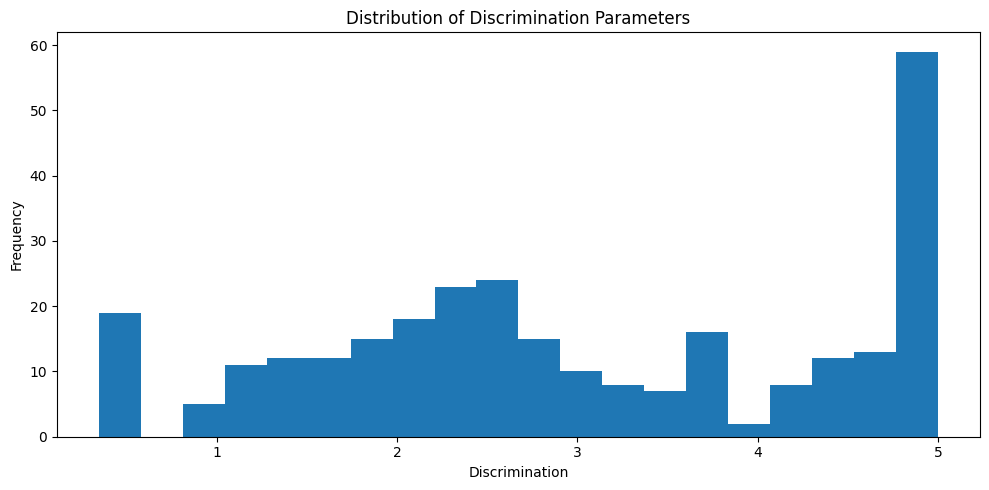

In [22]:
# graph of distribution of discrimination and difficulty across items
fig, ax1 = plt.subplots(figsize=(10, 5))

#disc
ax1.hist(output['Discrimination'], bins=20)
ax1.set_title('Distribution of Discrimination Parameters')
ax1.set_xlabel('Discrimination')
ax1.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
output_df = pd.DataFrame({"essay_id": common_ids, "Discrimination": output['Discrimination']})
for i in range(output['Difficulty'].shape[1]):
    output_df[f'Difficulty_Threshold_{i+1}'] = output['Difficulty'][:, i]
output_df.head()

,essay_id,Discrimination,Difficulty_Threshold_1,Difficulty_Threshold_2,Difficulty_Threshold_3,Difficulty_Threshold_4
0,9CDD8FC77D5A,4.995372,-0.986759,0.077898,0.766767,NaN
1,C19EDCF7BDD6,3.050570,-0.833307,0.624916,NaN,NaN
2,99D067A7FA9C,4.999994,-0.986656,-0.574488,0.236792,NaN
3,8E40E03B113A,2.942298,-1.083504,-0.630469,-0.085858,1.83389
4,9A96A89DF959,2.264793,-1.173635,-0.092801,0.681897,NaN


In [24]:
# #drop anything with non filled in thresholds -- should I do this? idk lol
# output_df = output_df.dropna()
# output_df.head()

In [25]:
most_discriminative = output_df.nlargest(5,'Discrimination')
most_discriminative.head()

,essay_id,Discrimination,Difficulty_Threshold_1,Difficulty_Threshold_2,Difficulty_Threshold_3,Difficulty_Threshold_4
243,CEACA9EC34F8,4.999997,-0.986656,-0.077887,1.261563,NaN
156,A9A0D8CE21B4,4.999996,-0.986656,-0.574488,1.663962,NaN
152,C537E278BAE6,4.999996,-0.986656,-0.077887,0.766690,NaN
229,AA7B4CC7EE1B,4.999996,-0.986656,0.077887,0.986656,NaN
151,04FA62C5F269,4.999996,-0.986656,-0.236792,0.986656,NaN


In [26]:
least_discriminative = output_df.nsmallest(5,'Discrimination')
least_discriminative.head()

,essay_id,Discrimination,Difficulty_Threshold_1,Difficulty_Threshold_2,Difficulty_Threshold_3,Difficulty_Threshold_4
190,80172B0A969C,0.346396,-5.947595,-1.059417,2.597016,NaN
33,480C577BC8C9,0.346396,-5.947592,1.059416,4.557241,NaN
171,FC9DA73D1EA0,0.346396,-5.947592,0.349930,4.557241,NaN
195,6AB122D640E1,0.346396,-5.947592,0.349930,4.557241,NaN
210,A6745A8EE7AF,0.346396,-5.947592,1.059416,4.557241,NaN


In [27]:
most_disc_ex = '''
As we have two different people, we have two types of parents that one of them, they believe and they force their children that should take some classes like music, drama, or an art class instead of elective classes. But another parents they do not believe and force them to take those classes. On the other hand we have some students that they like to take elective classes instead of those classes; and in opposite, we have students that they do not like to take elective classes.

In general, as we know the place of schools, we can easily discover that students need have some classes that they want to be and they like to enjoy it and has fun and exciting for them. Here are some reasons that is showed why they have to take those classes; like music, a drama, or an art class. First reason is if they took those classes, they can decrease their stress that they have in their life and their school. Second reason is, they can easily figure out what skills are they have in their life and out of the main classes in school. Third reason is, if they really learned from those classes, they can teach to another persons and get money for that. Fourth reason is, it is good for their health from all aspects. Fifth reason is, it gives them energy; so they can always be active in their life specially in their school.

First, on the other hand, some students is special because maybe they came from another country or have special condition that they not required to take those classes because they have to graduate or because of their English language; so they have to study and practice more; and they can not require to take those classes. They have to take main and elective classes that their counselor suggested to them. for example, I came from another country so I have to practice more in my English language and other main classes that I have in school, for these reasons I could not take an art, music or a drama class.

Second, another students just take those classes because their parents want to, so these students can not learn and enjoy from those classes and even they will hate from those classes. for example, I saw my friends that he took a music class but he did not like that, but their parents force and required him to take that class, in summary he fell from all classes that he had in his school, and finally he did not graduate from school because of that.

Third, some students that know English language include writing, speaking and listening, and has all A's in their main classes like Physics, Math and Chemistry and another main classes, they can take music, an art or a drama class. As I said some benefit of those classes on above, they can improve their skills and they can go in forward to their life that they want to be.

Finally, those classes can be help students a lot, but it has hinge on their status, and no one should not force students to take those classes unless they want to and they like to take those classes.

In conclusion, those classes should not be compulsory, because in general, each work should has be with love, until we can learn and help others and improve ourselves.
'''

least_disc_ex = '''
I am sure my heart is raising that I saw a lot of people behavior is going bazaar! Then it is said that your own behavior is the best way to influence other people because it creates trust, shows that your helping others, and creates a positive big impact on others.

Your own behavior creates trust is to show that other can respect you and care about you. Friends behavior creates trust because they will sometimes help others. For example, if i have a huge injury and I can't walk, then probably they'll know that I'm not joking around and I'll trust them to help me. Another person behavior that creates trust is teachers, their behavior is mostly positive and always influence others. They'll always care about helping their student and makes the student trust the teacher what they need help on. Even though students think that teacher dont trust them, but others think teachers have faith on others to try hard to help and let them work hard for the future. Also, families creates trust so they will always have influence on me. It like i made their personality more positive than before. Your own behavior creates trust because of helping others, having positive personality, and increase better relationship on others.

Showing that you help others is another way to influence other people from your own behavior. Sometimes my families help others and they will never forget about us. Like all of our family went to Generic_City and went on a mission to help others, like we build houses or feed a lot of poor people with food that we made. Another person that help others is friends, they always help me if i'm in a stress zone. They always comfort me feel better when I'm upset or mad. Also, teachers help other because they want the students to past the school. Although some of them might fail, yet teachers try their best to let them past. They want them to try hard so teachers need to make them work hard and help them learn. Like my teachers will try their best to help me past my quizzes or test. Helping others is the best way to influence people like friends, teachers, and families that they will support you and others what they need.

The reason why your own behavior creates a big positive impact of others. So more and more people will show respect and will mostly love you. This will create a big positive impact on friends because I show love for them and they will probably love me back. All of us should always show love and care so that they wont hate you. For families, they always have a positive impact because of others positive attitude. Showing a good attitude can be like walking the bridge to their heart. This can help their feeling be better and better. Another person that have a big impact on others is firefighters. They always care about others and their lives so they always protect them when they're in trouble. There was one story that these firefighters that they need equipment because their tools is rusty and broken, but one person called them for help so they came the house was on fire and the wife is still trapped. So they got her out and she is save. So the husband so so proud, and send them 2,000 dollars a month so the firefighter can bye the equipment. This it to show how much the husband care about them. So this can create a big positive impact because of showing love, fixing feelings, and having risk to protect.

Other might say that your own behavior can affect others. It has said that you own be behavior can influence other by showing that you help others create a positive big impact, and creates trust. We should see if others behavior can influence others and change the world.
'''


In [38]:
most_difficult = output_df.nlargest(10,'Difficulty_Threshold_1')
most_difficult.head()

,essay_id,Discrimination,Difficulty_Threshold_1,Difficulty_Threshold_2,Difficulty_Threshold_3,Difficulty_Threshold_4
223,A1A83A14B53F,0.540903,-0.232692,2.315582,NaN,NaN
228,87692B9A8184,2.022910,-0.495376,0.711384,NaN,NaN
96,17C7C1CAF7E8,1.473451,-0.574384,0.825529,NaN,NaN
191,A0B58CDB939A,1.384483,-0.594455,0.350826,NaN,NaN
240,36311D8E825C,2.239282,-0.684621,0.476853,NaN,NaN


In [39]:
least_difficult = output_df.nsmallest(10,'Difficulty_Threshold_1')
least_difficult.head()

,essay_id,Discrimination,Difficulty_Threshold_1,Difficulty_Threshold_2,Difficulty_Threshold_3,Difficulty_Threshold_4
190,80172B0A969C,0.346396,-5.947595,-1.059417,2.597016,NaN
33,480C577BC8C9,0.346396,-5.947592,1.059416,4.557241,NaN
210,A6745A8EE7AF,0.346396,-5.947592,1.059416,4.557241,NaN
171,FC9DA73D1EA0,0.346396,-5.947592,0.349930,4.557241,NaN
195,6AB122D640E1,0.346396,-5.947592,0.349930,4.557241,NaN


In [45]:
def numwords(string):
    words = string.split()
    return len(words)

originals = pd.read_csv("/content/drive/MyDrive/senior_thesis/essay_grading/ellipse_dataset.csv")
originals['Length'] = originals['full_text'].apply(numwords)
originals.head()

,text_id_kaggle,full_text,gender,grade,race_ethnicity,num_words,num_words2,num_words3,num_sent,num_para,...,SES,prompt,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions,Length
0,5AA45740A848,"Dear, TEACHER_NAME\n\nI think phone policy at ...",Male,8,Hispanic/Latino,111,122,118,7,2,...,Economically disadvantaged,Cell phones at school,3.0,3.5,2.5,3.5,3.0,3.5,2.5,118
1,790891A35047,"Dear, Principal\r\n\r\nIn my opinion, I think ...",Female,8,Hispanic/Latino,99,105,102,6,2,...,Economically disadvantaged,Cell phones at school,3.0,2.5,3.0,4.0,3.5,3.0,3.5,102
2,C254D74362A3,PHONES\n\nDear principal students should have ...,Female,8,Hispanic/Latino,121,134,128,4,2,...,Economically disadvantaged,Cell phones at school,3.0,2.5,3.0,3.0,3.0,3.5,3.0,128
3,0985602832CD,phones\n\ni think phones should be allowed in ...,Male,8,Hispanic/Latino,182,202,192,2,2,...,Economically disadvantaged,Cell phones at school,3.0,2.0,2.5,3.0,3.0,3.0,2.5,192
4,3AB3FC197550,Do you really think students need cell phones ...,Female,8,Hispanic/Latino,192,210,201,11,4,...,Not economically disadvantaged,Cell phones at school,3.0,2.0,3.0,3.0,3.0,3.0,2.0,201


In [46]:
# prompt: using the originals dataset as a reference (on text_id_kaggle = essay_id) make a dataframe each for low discrimination, high discrimination, low difficulty, and high difficulty items with id, length, prompt, and grade

import pandas as pd
import numpy as np
# Merge discrimination and difficulty data with the originals dataset
merged_df = pd.merge(output_df, originals, left_on='essay_id', right_on='text_id_kaggle', how='left')

# Create dataframes for each category
low_discrimination_df = merged_df[merged_df['Discrimination'] <= np.quantile(merged_df['Discrimination'], 0.25)][['text_id_kaggle', 'Length', 'prompt', 'Overall']]
high_discrimination_df = merged_df[merged_df['Discrimination'] >= np.quantile(merged_df['Discrimination'], 0.75)][['text_id_kaggle', 'Length', 'prompt', 'Overall']]
low_difficulty_df = merged_df[merged_df['Difficulty_Threshold_1'] <= np.quantile(merged_df['Difficulty_Threshold_1'], 0.25)][['text_id_kaggle', 'Length', 'prompt', 'Overall']]
high_difficulty_df = merged_df[merged_df['Difficulty_Threshold_1'] >= np.quantile(merged_df['Difficulty_Threshold_1'], 0.75)][['text_id_kaggle', 'Length', 'prompt', 'Overall']]

# Rename columns for consistency
low_discrimination_df = low_discrimination_df.rename(columns={'text_id_kaggle': 'id', 'Overall': 'grade'})
high_discrimination_df = high_discrimination_df.rename(columns={'text_id_kaggle': 'id', 'Overall': 'grade'})
low_difficulty_df = low_difficulty_df.rename(columns={'text_id_kaggle': 'id', 'Overall': 'grade'})
high_difficulty_df = high_difficulty_df.rename(columns={'text_id_kaggle': 'id', 'Overall': 'grade'})

# Display the first few rows of each dataframe (optional)
print("Low Discrimination Items:")
print(low_discrimination_df.head())

print("\nHigh Discrimination Items:")
print(high_discrimination_df.head())

print("\nLow Difficulty Items:")
print(low_difficulty_df.head())

print("\nHigh Difficulty Items:")
print(high_difficulty_df.head())


Low Discrimination Items:
              id  Length                          prompt  grade
15  55AEC9A9BB4C     497              Positive attitudes    3.0
18  D5AC4A35BAF8     372                      Being busy    3.5
20  662E92CD6A6E     435           Curfews for teenagers    4.0
25  4E81E4116D94     414  Three-year high school program    2.5
28  62A6A91A2C46     291                         Honesty    3.0

High Discrimination Items:
              id  Length                  prompt  grade
0   9CDD8FC77D5A     290  Spending time outdoors    3.0
2   99D067A7FA9C     506       Career commitment    4.0
5   C4472C6DFE66     431   Praising student work    3.0
7   8C44127FF83C     640      Letter to employer    3.0
10  4C6E08E611EA     332         Places to visit    3.5

Low Difficulty Items:
              id  Length                          prompt  grade
4   9A96A89DF959     797               Career commitment    3.5
8   1FB9B9E08786     343                      Being busy    3.0
18  D5AC4A3

In [47]:
# prompt: make a dataframe with average length and most frequent prompt(s) for the high and low discrimination and difficulty dataframes

import pandas as pd
def summarize_dataframe(df):
    """
    Calculates the average length and most frequent prompts for a given DataFrame.
    """
    avg_length = df['Length'].mean()
    most_frequent_prompts = df['prompt'].mode().tolist()  # Convert to list to handle multiple modes

    return avg_length, most_frequent_prompts


# Calculate summaries for each dataframe
low_disc_avg_length, low_disc_prompts = summarize_dataframe(low_discrimination_df)
high_disc_avg_length, high_disc_prompts = summarize_dataframe(high_discrimination_df)
low_diff_avg_length, low_diff_prompts = summarize_dataframe(low_difficulty_df)
high_diff_avg_length, high_diff_prompts = summarize_dataframe(high_difficulty_df)


# Create the summary DataFrame
summary_df = pd.DataFrame({
    'Category': ['Low Discrimination', 'High Discrimination', 'Low Difficulty', 'High Difficulty'],
    'Average Length': [low_disc_avg_length, high_disc_avg_length, low_diff_avg_length, high_diff_avg_length],
    'Most Frequent Prompt(s)': [low_disc_prompts, high_disc_prompts, low_diff_prompts, high_diff_prompts]
})

summary_df


,Category,Average Length,Most Frequent Prompt(s)
0,Low Discrimination,443.602740,[Being busy]
1,High Discrimination,428.561644,[Self-reliance]
2,Low Difficulty,458.630137,[Being busy]
3,High Difficulty,442.026667,[Career commitment]


In [30]:
most_diff_ex = '''
Every day all the people in the world make a lot decisions and each one have different way to decided. Sometimes you have you have to ask for help, becasue there is a lot of people with experienced for example, parents,teachers and experts. I think decisions can affect your future and also can affect other people. Adults, specially old people have a lot advices for you to be a better person.

First of all, decisions are the key of the one person and can affect the future for the rest of the life. For example,education is one of the most important thing in the life, and that's why your parents always keep saying go to school, and finish the high school that advice is given to you because they want to see a better future for you and you have to listen because is the experienced that is talk is not your parents.

Second, adults have a lot of experience specially old people (grandmother and grandparent).For example, every time when your parents talk for your future, they know about the life because all they have experienced and maybe when they were young, make a bad decisions and that's why the given to you a lot advices because they worried about you.

Finally, most of the time specially (young girls and boys) when they decided something always is wrong because they only care they self but that decisions can affect other people. For expample I from Generic_City and in my country all the time you see young people make the decision to drop out of school and get to the gangs. As a result, they get to the jail or they died and the only people who cry is your family bacuse they want all the best for you.

In conclusion make decisions is not easy for each one because some are easily and some are hard, but I think you shoot ask all the time first for help with your parents and with experts because they have a lot experienced.
'''


least_diff_ex = '''
Dear principal

The students and I have been thinking to ask you if you can change the schools policy to a grade C .The reason is that the students will be able to participate in sports or school activities.

Students want to be able be in the schools teams and the students want to have fun in school .

If we need to get B average and many of the students are C average

it would not be fair to the C average students. So can the policy change .

by students
'''


In [31]:
#generate item response category characteristic curves for a given item

def plot_icc(item_index):
    """
    Generate item response category characteristic curves
    thetas: array with thetas
    Discrimination: single number for disc
    Difficulty: array with thresholds
    """
    theta = output['Ability']
    theta = np.array(theta)
    theta = np.sort(theta)

    discrimination = output_df['Discrimination'][item_index]
    discrimination = np.array(discrimination)

    difficulty = output['Difficulty'][item_index]
    difficulty = np.array(difficulty)


    #drop na threshold vals
    difficulty = difficulty[np.logical_not(np.isnan(difficulty))]

        # Calculate cumulative category probabilities
    cum_probs = []
    for diff in difficulty:
        logit = discrimination * (theta - diff)
        p = 1 / (1 + np.exp(-logit))
        cum_probs.append(p)
    cum_probs = np.array(cum_probs)

    # Calculate category probabilities
    k = len(difficulty) + 1  # number of categories
    cat_probs = np.zeros((k, len(theta)))

    # First category (0)
    cat_probs[0] = 1 - cum_probs[0]

    # Middle categories
    for i in range(1, k-1):
        cat_probs[i] = cum_probs[i-1] - cum_probs[i]

    # Last category
    cat_probs[-1] = cum_probs[-1]

    # Plotting
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i in range(k):
        plt.plot(theta, cat_probs[i], color=colors[i],
                label=f'Category {i}', linewidth=2)

    plt.xlabel('Theta (Ability)')
    plt.ylabel('Probability')
    plt.title(f'Item {item_index}: Category Response Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(min(theta), max(theta))
    plt.ylim(0, 1)
    plt.show()


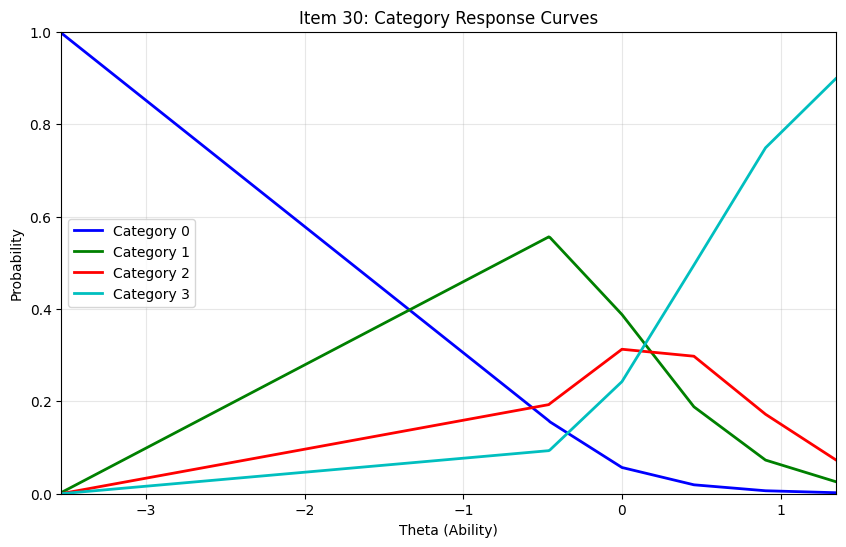

In [32]:
plot_icc(30)

In [33]:
category_data['overall'].columns

Index(['llama-3.2-3b', 'llama-3.2-1b', 'gemma-2-2b', 'gemma-2b',
       'llama-3-8b-it', 'gemma-1.1-2b-it', 'gemma-2-2b-it', 'llama-3.2-1b-it',
       'llama-3.2-3b-it', 'gemma-7b', 'flan-t5-large', 'qwen-2.5-1.5b-it',
       'qwen-2.5-0.5b-it', 'qwen-2.5-3b-it', 'qwen-2.5-7b-it-1m',
       'phi-3-mini-4k-it', 'phi-3.5-mini-instruct'],
      dtype='object')

## Comparing to benchmarks?

In [34]:
#df for abilities from output
thetas = pd.DataFrame({"Model": category_data['overall'].columns, "Theta": output['Ability']})
thetas.head()

,Model,Theta
0,llama-3.2-3b,4.537396e-01
1,llama-3.2-1b,-7.916349e-10
2,gemma-2-2b,1.350838e+00
3,gemma-2b,4.537396e-01
4,llama-3-8b-it,-4.537396e-01


In [35]:
benchmarks = pd.read_csv("https://docs.google.com/spreadsheets/d/1wIkHngYOwSewOlVM7PquMqpH338uBEKKwPQSv6tEuzs/export?format=csv")
benchmarks.head()


,Model,IFEval,Big_Bench_Hard,MuSR,Theta_GRM,Theta_2pl,Theta_1pl
0,flan-t5-large,22.01,17.51,9.01,1.28,1.08,0.96
1,gemma-1.1-2b-it,30.67,5.86,2.02,-0.56,-0.38,0.03
2,gemma-2-2b,19.93,11.76,11.43,0.81,1.57,1.80
3,gemma-2-2b-it,56.68,17.98,7.08,-0.84,-0.59,-0.34
4,gemma-2b,26.90,5.21,3.03,1.42,0.59,0.49


In [36]:
stats = pd.merge(benchmarks, thetas)
stats.head()

,Model,IFEval,Big_Bench_Hard,MuSR,Theta_GRM,Theta_2pl,Theta_1pl,Theta
0,flan-t5-large,22.01,17.51,9.01,1.28,1.08,0.96,0.904880
1,gemma-1.1-2b-it,30.67,5.86,2.02,-0.56,-0.38,0.03,-3.534131
2,gemma-2-2b-it,56.68,17.98,7.08,-0.84,-0.59,-0.34,-3.534131
3,gemma-2b,26.90,5.21,3.03,1.42,0.59,0.49,0.453740
4,gemma-7b,26.59,21.12,10.98,1.13,1.41,1.72,1.350838


In [37]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_minmax = MinMaxScaler()
stats_minmax = stats.copy()
stats_minmax[["IFEval", "Big Bench Hard", "MuSR", "Theta"]] = scaler_minmax.fit_transform(stats[["IFEval", "Big Bench Hard", "MuSR", "Theta"]])

# # should z score instead maybe??? Idk girl
# scaler_std = StandardScaler()
# stats_std = stats.copy()
# stats_std[["IFEval", "Big Bench Hard", "MuSR", "Theta"]] = scaler_std.fit_transform(stats[["IFEval", "Big Bench Hard", "MuSR", "Theta"]])

print(stats_minmax.head())
# print(stats_std.head())


KeyError: "['Big Bench Hard'] not in index"

In [ ]:
def get_theta_info(stats):

  from scipy.stats import spearmanr

  correlations = {col: spearmanr(stats["Theta"], stats[col])[0] for col in ["IFEval", "Big Bench Hard", "MuSR"]}
  print("Spearman Correlations with Theta:", correlations)

    #explained variance
  from sklearn.linear_model import LinearRegression
  X = stats[["IFEval", "Big Bench Hard", "MuSR"]]
  y = stats["Theta"]
  reg = LinearRegression().fit(X, y)
  r_squared = reg.score(X, y)
  print("R² of Theta predicting benchmarks:", r_squared)

In [ ]:
get_theta_info(stats_minmax)

In [ ]:

output_cohesion = grm(category_data['cohesion'].to_numpy().astype(int))
theta_cohesion = pd.DataFrame({"Model": category_data['overall'].columns, "Theta": output_cohesion['Ability']})

In [ ]:

stats2 = pd.merge(benchmarks, theta_cohesion)
stats2.head()

get_theta_info(stats2)

In [ ]:

output_vocab = grm(category_data['vocabulary'].to_numpy().astype(int))
theta_vocab = pd.DataFrame({"Model": category_data['overall'].columns, "Theta": output_vocab['Ability']})

stats_vocab = pd.merge(benchmarks, theta_vocab)
stats_vocab.head()

get_theta_info(stats_vocab)

In [ ]:

output_syntax = grm(category_data['syntax'].to_numpy().astype(int))
theta_syntax = pd.DataFrame({"Model": category_data['overall'].columns, "Theta": output_syntax['Ability']})

stats_syntax = pd.merge(benchmarks, theta_syntax)
stats_syntax.head()

get_theta_info(stats_syntax)